# Mask R-CNN - Test on Shapes Dataset

Run the Mask R-CNN net in inference mode, with the additional PCILayer that generates the context-based tensor 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pprint
import keras.backend as KB
sys.path.append('../')

import mrcnn.model        as modellib
import mrcnn.visualize    as visualize
# import mrcnn.new_shapes   as shapes
import mrcnn.new_shapes  as new_shapes
# from mrcnn.new_shapes  import NewShapesDataset, NewShapesConfig
from mrcnn.config      import Config
from mrcnn.model       import log
from mrcnn.dataset     import Dataset 
# from mrcnn.pc_prototype import PCTensor
# from mrcnn.pcn_layer    import PCNLayer, PCILayer
from mrcnn.datagen import data_generator, load_image_gt
# Root directory of the project
ROOT_DIR = os.getcwd()
MODEL_PATH = 'E:\Models'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
# Path to COCO trained weights
COCO_MODEL_PATH   = os.path.join(MODEL_PATH, "mask_rcnn_coco.h5")
RESNET_MODEL_PATH = os.path.join(MODEL_PATH, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100)

# Build configuration object -----------------------------------------------
config = new_shapes.NewShapesConfig()
config.BATCH_SIZE      = 2                    #Batch size is 2 (# GPUs * images/GPU).
config.IMAGES_PER_GPU  = 2
config.STEPS_PER_EPOCH = 7
config.IMAGES_PER_GPU  = 1
config.display() 

# Build shape dataset        -----------------------------------------------

# from mrcnn.datagen import data_generator, load_image_gt

# Training dataset generate 500 shapes 
dataset_test = new_shapes.NewShapesDataset()
dataset_test.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_test.prepare()

# Validation dataset
# dataset_val = shapes.NewShapesDataset()
# dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
# dataset_val.prepare()

# Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 3)
# for image_id in [3]:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
import pprint
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=130 , precision=4, threshold=2000)

D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorflow Version: 1.6.0   Keras Version : 2.1.4 
 Initialize config object - super
(56, 56)

Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EPOCHS_TO_RUN                  0
FCN_INPUT_SHAPE                [128 128]
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LAST_EPOCH_RAN                 0
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [12

 Add image --->  160
 Add image --->  161
 Add image --->  162
 Add image --->  163
 Add image --->  164
 Add image --->  165
 Add image --->  166
 !!!!!!  Zero Mask Found !!!!!!
 ===> Find Hidden Shapes() found hidden objects 
[ ('sun', (147, 97, 94), (34, 7, 4, 4)),
  ('tree', (120, 89, 137), (84, 79, 17, 17)),
  ('building', (239, 135, 55), (76, 82, 19, 28)),
  ('building', (232, 24, 56), (90, 83, 19, 29)),
  ('tree', (59, 163, 117), (39, 89, 19, 19))]
 ****** Objects completely hidden are :  [1]
('tree', (120, 89, 137), (84, 79, 17, 17))
( 166 ) ------ shapes after removeal of totally hidden shapes ------
[ ('sun', (147, 97, 94), (34, 7, 4, 4)),
  ('building', (239, 135, 55), (76, 82, 19, 28)),
  ('building', (232, 24, 56), (90, 83, 19, 29)),
  ('tree', (59, 163, 117), (39, 89, 19, 19))]
    Number of shapes now is :  4
 Add image --->  167
 Add image --->  168
 Add image --->  169
 Add image --->  170
 Add image --->  171
 Add image --->  172
 Add image --->  173
 Add image --->  

 Add image --->  471
 Add image --->  472
 Add image --->  473
 Add image --->  474
 Add image --->  475
 Add image --->  476
 Add image --->  477
 Add image --->  478
 Add image --->  479
 Add image --->  480
 Add image --->  481
 Add image --->  482
 Add image --->  483
 Add image --->  484
 Add image --->  485
 Add image --->  486
 Add image --->  487
 Add image --->  488
 Add image --->  489
 Add image --->  490
 Add image --->  491
 Add image --->  492
 Add image --->  493
 Add image --->  494
 Add image --->  495
 Add image --->  496
 Add image --->  497
 Add image --->  498
 Add image --->  499


In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Detection

In [3]:
class InferenceConfig(new_shapes.NewShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display() 

 Initialize config object - super
(56, 56)

Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EPOCHS_TO_RUN                  0
FCN_INPUT_SHAPE                [128 128]
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LAST_EPOCH_RAN                 0
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56

### Build the model

In [4]:
# Recreate the model in inference mode
try :
    del model
    gc.collect()
except: 
    pass
KB.clear_session()


model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180510T1355\mask_rcnn_shapes_{epoch:04d}.h5
    set_log_dir: self.epoch set to 0 

>>> Resnet Graph 
     Input_image shape : (?, 128, 128, 3)
     After ZeroPadding2D  : (?, 134, 134, 3) (?, 134, 134, 3)
     After Conv2D padding : (?, 64, 64, 64) (?, 64, 64, 64)
     After BatchNorm      : (?, 64, 64, 64) (?, 64, 64, 64)
     After MaxPooling2D   : (?, 32, 32, 64) (?, 32, 32, 64)

>>> Feature Pyramid Network (FPN) Graph 
     FPN P2 shape : (None, 32, 32, 256)
     FPN P3 shape : (None, 16, 16, 256)
     FPN P4 shape : (None, 8, 8, 256)
     FPN P5 shape : (None, 4, 4, 256)
     FPN P6 shape : (None, 2, 2, 256)

>>> RPN Layer 
     Input_feature_map shape : (?, ?, ?, 256)
     anchors_per_location    : 3
     depth                   : 256
     Input_feature_map shape : (?, ?, ?, 256)
     anchors_per_location    : 3
     anchor_stride           : 1

>>> RPN Outputs  <class 'list'>
      rpn_class_logits/concat:0
 

In [5]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]
print(' last weights file found:', model_path )
model_path  = 'E:\\Models\\mrcnn_logs\\shapes20180509T1928\\mask_rcnn_shapes_2192.h5'
print(' last weights to be used:', model_path )
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

 last weights file found: E:\Models\mrcnn_logs\shapes20180509T1928\mask_rcnn_shapes_2500.h5
 last weights to be used: E:\Models\mrcnn_logs\shapes20180509T1928\mask_rcnn_shapes_2192.h5
Loading weights from  E:\Models\mrcnn_logs\shapes20180509T1928\mask_rcnn_shapes_2192.h5
>>> load_weights()
    load_weights: Loading weights from: E:\Models\mrcnn_logs\shapes20180509T1928\mask_rcnn_shapes_2192.h5
 layers to load 
----------------
>layer 0 : name : input_image                               type: <keras.engine.topology.InputLayer object at 0x000001E429791080>
>layer 1 : name : zero_padding2d_1                          type: <keras.layers.convolutional.ZeroPadding2D object at 0x000001E42EDA6550>
>layer 2 : name : conv1                                     type: <keras.layers.convolutional.Conv2D object at 0x000001E434E47E80>
>layer 3 : name : bn_conv1                                  type: <mrcnn.batchnorm_layer.BatchNorm object at 0x000001E434E47E10>
>layer 4 : name : activation_1           

    load_weights: Log directory set to : E:\Models\mrcnn_logs\shapes20180509T1928\mask_rcnn_shapes_2192.h5
    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180509T1928\mask_rcnn_shapes_{epoch:04d}.h5
    set_log_dir: self.epoch set to 2193 
    Load weights complete :  E:\Models\mrcnn_logs\shapes20180509T1928\mask_rcnn_shapes_2192.h5


'E:\\Models\\mrcnn_logs\\shapes20180509T1928\\mask_rcnn_shapes_2192.h5'

###  Print some information about the model 

In [ ]:
# model.compile_only(learning_rate=config.LEARNING_RATE, layers='heads')
# print('\n Metrics (_get_deduped_metrics_names():) ') 
# pp.pprint(mm._get_deduped_metrics_names())
# print('\n Losses (model.metrics_names): ') 
# pp.pprint(mm.metrics_names)
KB.set_learning_phase(0)
print(' Learning phase values is L ' ,KB.learning_phase())
print('\n Inputs: ') 
pp.pprint(model.keras_model.inputs)
print('\n Outputs: ') 
pp.pprint(model.keras_model.outputs)
# print('\Layers')
# pp.pprint(model.keras_model.layers)
# weights = model.keras_model.get_weights()
# print(' Number of weights arrays: ',len(weights))
print('\n Weights: ') 
print('length of model.keras_model.weights', len(model.keras_model.weights))
pp.pprint(model.keras_model.weights)
# pp.pprint(dir(model.keras_model))
print(model.keras_model.weights[1])

### Test on a random image

In [6]:
# Test on a random image
# Validation dataset
# dataset_val = shapes.ShapesDataset()
# dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
# dataset_val.prepare()

image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    load_image_gt(dataset_test, inference_config, image_id, use_mini_mask=False)
    

Image Id : 422
[ ('cloud', (217, 7, 134), (22, 20, 15, 3)),
  ('cloud', (19, 242, 160), (10, 22, 19, 6)),
  ('cloud', (190, 177, 95), (47, 24, 23, 4))]
original_image           shape: (128, 128, 3)         min:    7.00000  max:  242.00000
image_meta               shape: (15,)                 min:    0.00000  max:  422.00000
[422 128 128   3   0   0 128 128   1   1   1   1   1   1   1]
gt_class_id              shape: (3, 4)                min:    0.00000  max:   71.00000
gt_bbox                  shape: (3, 4)                min:    0.00000  max:   71.00000
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    1.00000
 1: person   2: car  3: sun  4: building  5: tree  6: cloud 


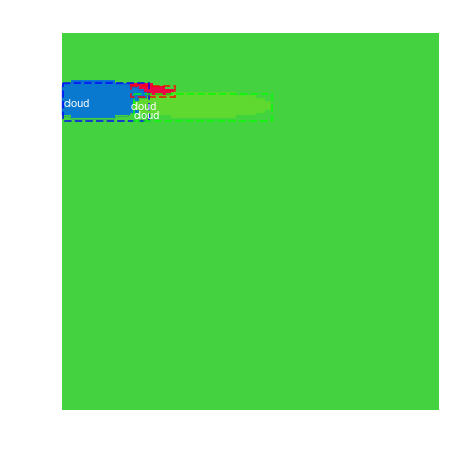

In [7]:
print('Image Id :', image_id)    
shape_list = dataset_test.image_info[image_id]['shapes']
pp.pprint(shape_list)
log("original_image", original_image)
log("image_meta", image_meta)
print(image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

print(" 1: person   2: car  3: sun  4: building  5: tree  6: cloud ")
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_test.class_names, figsize=(8, 8))

In [8]:
results = model.detect([original_image], verbose=1)

Processing 1 images
image                    shape: (128, 128, 3)         min:    7.00000  max:  242.00000
molded_images            shape: (1, 128, 128, 3)      min: -109.80000  max:  125.20000
image_metas              shape: (1, 15)               min:    0.00000  max:  128.00000


  rois       :  [[17  0 28 29]
 [20 26 29 69]]
  masks      :  (128, 128, 2)
  class ids  :  [6 6]
  class names:  ['BG', 'person', 'car', 'sun', 'building', 'tree', 'cloud']
  scores     :  [0.9985 0.9977]


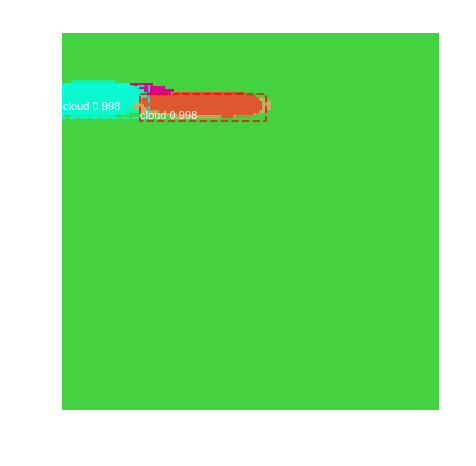

In [9]:
r = results[0]
print('  rois       : ', r['rois'])
print('  masks      : ', r['masks'].shape)
print('  class ids  : ', r['class_ids'])
print('  class names: ', dataset_test.class_names)
print('  scores     : ', r['scores'])
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

## Evaluation

In [11]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
from mrcnn.datagen     import data_generator, load_image_gt
import  mrcnn.utils as utils 

image_ids = np.random.choice(dataset_test.image_ids, 100)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(utils.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.9708690481632948


### Get next shapes from generator and display loaded shapes

## Save 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Notebook Preferences

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Configurations

In [ ]:
# from keras import backend as KB
# if 'tensorflow' == KB.backend():
#     import tensorflow as tf
#     from keras.backend.tensorflow_backend import set_session
#     # tfconfig = tf.ConfigProto(
#         # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5),
#         # device_count = {'GPU': 1}
#     # )    
#     tfconfig = tf.ConfigProto()
#     tfconfig.gpu_options.allow_growth=True
#     tfconfig.gpu_options.visible_device_list = "0"
#     tfconfig.gpu_options.per_process_gpu_memory_fraction=0.5
#     tf_sess = tf.Session(config=tfconfig)
#     set_session(tf_sess)

###  Simulation of `detect()` routine

In [ ]:
# print('>>> model detect()')
verbose = 1
images  = [original_image]
assert model.mode   == "inference", "Create model in inference mode."
assert len(images) == model.config.BATCH_SIZE, "len(images) must be equal to BATCH_SIZE"

if verbose:
    log("Processing {} images".format(len(images)))
    for image in images:
        log("image", image)

# Mold inputs to format expected by the neural network
molded_images, image_metas, windows = model.mold_inputs(images)
if verbose:
    log("molded_images", molded_images)
    log("image_metas"  , image_metas)

## Run object detection pipeline
# print('    call predict()')
detections, rpn_rois, rpn_class, rpn_bbox,\
            mrcnn_class, mrcnn_bbox, mrcnn_mask \
                      =  model.keras_model.predict([molded_images, image_metas], verbose=0)

print('    return from  predict()')
print('    Length of detections : ', len(detections))
print('    Length of rpn_rois   : ', len(rpn_rois   ))
print('    Length of rpn_class  : ', len(rpn_class  ))
print('    Length of rpn_bbox   : ', len(rpn_bbox   ))
print('    Length of mrcnn_class: ', len(mrcnn_class))
print('    Length of mrcnn_bbox : ', len(mrcnn_bbox ))
print('    Length of mrcnn_mask : ', len(mrcnn_mask ))

####  detection array layout is `[ y1, x1, y2, x2, class, score]`

detections[0].shape
print(detections[0])

## Process detections
results = []
for i, image in enumerate(images):
    final_rois, final_class_ids, final_scores, final_masks =\
        model.unmold_detections(detections[i], 
                               mrcnn_mask[i],
                               image.shape  ,
                               windows[i])
    results.append({
        "rois"     : final_rois,
        "class_ids": final_class_ids,
        "scores"   : final_scores,
        "masks"    : final_masks,
    })